# Model gas network

This notebook computes pressure and mass flow in a 

## Install the necessary library

In this part we install OSEM and the necessary python module.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# when git repository public
# !pip install git+..

# currently
mydir = r'W:\Enerapi\code\OSEM'
if mydir not in sys.path:
    sys.path.append(mydir)
import osem.networks.pandangas.network_creation as pg
import osem.networks.pandangas.run_simulation as pg_run
import osem.networks.pandangas.utilities as pg_uti

print('module loaded')

module loaded


# Create a gas model and plot the results

In [28]:
%%capture

# load the gas data (based on the shpaefile provided)
filename_gas = r'data_example/gas_network/data_gas_champignac.xlsx'
data_pipes = pd.read_excel(filename_gas)

# create am empty gas network
net = pg.create_empty_network()
id_loc = {}

# create bus/nodes
nodes1 = data_pipes[['x_s', 'y_s', 'pressure_s']]
nodes2 = data_pipes[['x_e', 'y_e', 'pressure_s']]
nodes2.columns = nodes1.columns = ['x', 'y', 'pressure']
nodes = pd.concat([nodes1, nodes2], ignore_index=True)
nodes.drop_duplicates(inplace=True)
for i,n in nodes.iterrows():
    b = pg.create_bus(net, level=n["pressure"], name=i)
    id_loc[(n["x"],n["y"])] = b

# create pipes
for index, row in data_pipes.iterrows():
    # start and end bus
    b1 = id_loc[(row["x_s"],row["y_s"])] 
    b2 = id_loc[(row["x_e"],row["y_e"])]
    length = np.sqrt((row["x_s"] -row["x_e"] )**2 +(row["y_s"] -row["y_e"] )**2)
    # create pipes
    pg.create_pipe(net, b1, b2,length_m=length, diameter_m=row["diameter"], name=index, check=False)

# add load at the start of the pipe
for index, row in data_pipes.iterrows():
    if row['load_kW'] > 0:
        b1 =  id_loc[(row["x_s"],row["y_s"])] 
        pg.create_load(net, b1, p_kW=row['load_kW'], name="LOAD" + str(b1))

# add one feeder
b1 = net.bus.index[0]
feeder = pg.create_feeder(net, b1, p_lim_kW=1e10, p_Pa='MP', name="FEEDER")
b1 = net.bus.index[-1]
feeder = pg.create_feeder(net, b1, p_lim_kW=1e10, p_Pa='MP', name="FEEDER2")

# run the simulation
a = pg_run.runpg(net)
    

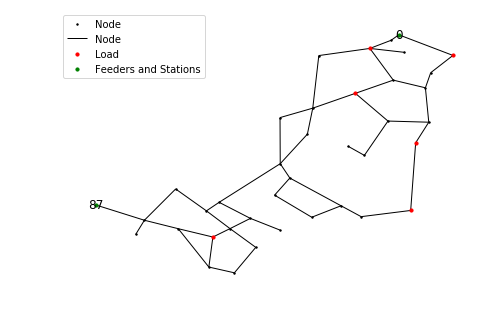

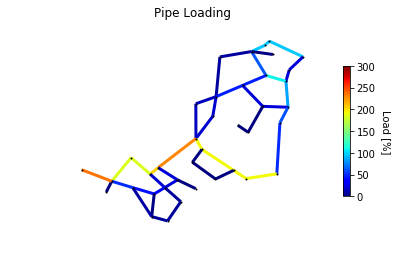

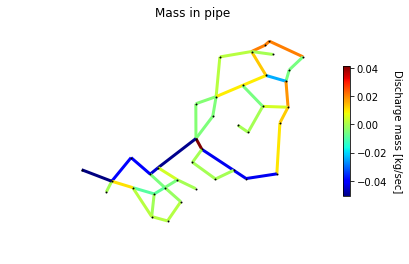

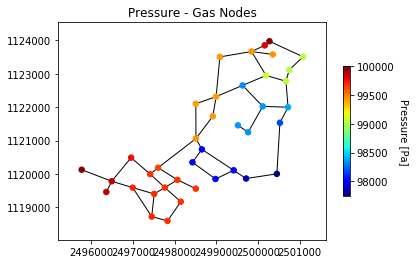

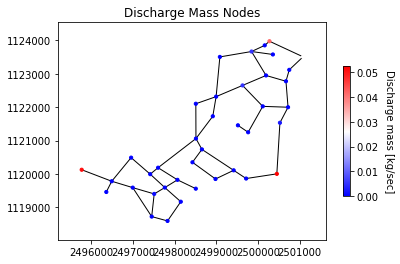

In [29]:
# plot and save results
pos = {v: k for k, v in id_loc.items()}
pg_uti.draw_results(net, pos)
# pg_uti.save_pandangas_net(net, 'test', save_result=True)